<a href="https://colab.research.google.com/github/FloxTBoTyy/Project-Portfolio-Data-Science/blob/main/recomender_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matriz de factorización con un red neuronal
***

Instalar la libreria:
pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
# Leemos ratings
df = pd.read_csv('ml-latest-small/ratings.csv')

In [ ]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
# Creamos los tokens para los users_id
user_ids = df["userId"].unique().tolist() # get lists of unique ids.
# Construimos dos diccionarios, uno que nos devuelve los tokens dado un user y viceversa
user2user_encoded = {x: i for i, x in enumerate(user_ids)} # get token from user
userencoded2user = {i: x for i, x in enumerate(user_ids)} # get user from token


# Hacemos los mismo con los movies ids.
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)} # get token from item
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)} # get item from token


# añadimos los tokens al dataframe
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

# Imprimos alguna información descriptiva como
# número de usuarios, de películas, máximo valor y mínimo de un rating,
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)

# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [ ]:
df.head()

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4


In [ ]:
df = df.sample(frac=1, random_state=42)

In [ ]:
df.head()

,userId,movieId,rating,timestamp,user,movie
67037,432,77866,4.5,1335139641,431,4730
42175,288,474,3.0,978465565,287,474
93850,599,4351,3.0,1498524542,598,2631
6187,42,2987,4.0,996262677,41,194
12229,75,1610,4.0,1158989841,74,727


In [ ]:
# Vamos a coger las muestras de train y test de forma manual.
# barajamos primero y luego cogemos el 80 % de los primeros índices
# para entrenamiento y el resto para validación
#df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
#y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
y = df["rating"].values
# Assuming training on 80% of the data and validating on 10%.
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [ ]:
len(x_train)

80668

In [ ]:
y_val[1]

np.float32(4.0)

In [ ]:
x_train[0]

array([ 431, 4730])

In [ ]:
# Construimos nuestra red neuronal simulando una matriz de factorización

EMBEDDING_SIZE = 10 # tamaño del vector de embeddings.


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        # construimos la capa de embeddings para users y movies.
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        # embedding users
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # bias users
        self.user_bias = layers.Embedding(num_users, 1)
        # embedding movies
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # bias movies

        self.movie_bias = layers.Embedding(num_movies, 1)




    def call(self, inputs):
        # en call encadenamos todas las capas

        # La entrada 0 del array es user tokens
        # lo usamos como entrada para user embeddings y user bias
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])

        # La entrada 1 del array es movies tokens
        # lo usamos para movie embeddings y bias
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])

        # finalmente, multiplicamos los vectores
        dot_user_movie = layers.Dot(axes=1)([user_vector, movie_vector])



        #dot_user_movie = keras.tensordot(user_vector, movie_vector, 2)

        # y les sumamos los bias.
        x = dot_user_movie + user_bias + movie_bias
        #d1 = self.dense1(tf.concat([user_vector, movie_vector]))
        #d2 = self.dense2(d1)
        #d3 = self.dense3(d2)
        #d4 = self.dense4(tf.concat([d3, x]))

        return x

    # Este metodo es necesario para guardar el modelo
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_users": self.num_users,
            "num_movies": self.num_movies,
            "embedding_size": self.embedding_size,
        })
        return config


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(learning_rate=0.001)
)

In [ ]:
# train with early stop for epoch
from keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=40,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/40
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 11.3139 - val_loss: 8.6942
Epoch 2/40
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.3791 - val_loss: 3.2037
Epoch 3/40
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.2681 - val_loss: 1.9498
Epoch 4/40
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4739 - val_loss: 1.4972
Epoch 5/40
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1383 - val_loss: 1.2777
Epoch 6/40
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.9601 - val_loss: 1.1530
Epoch 7/40
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8536 - val_loss: 1.0790
Epoch 8/40
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7842 - val_loss: 1.0317
Epoch 9/40
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7369 - val_loss: 1.0008
Epoch 10/40
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7021 - val_loss: 0.9811
Epoch 11/40
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6759 - val_loss: 0.9678
Epoch 12/40
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/ste

In [ ]:
#print(model(x_val[0:15]))
print(max(y_val))

5.0


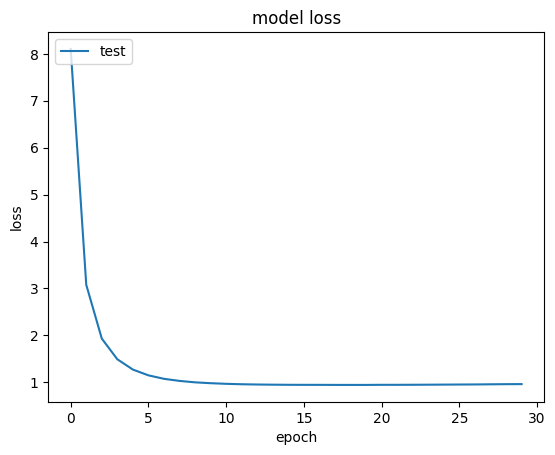

In [ ]:
#plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend([ "test"], loc="upper left")
plt.show()

In [ ]:
# get the validation final error executing the model for all the validation set
final_val_loss = history.history["val_loss"][-1]
print("Final validation loss: {:.4f}".format(final_val_loss))

Final validation loss: 0.9661


In [ ]:
#store model to be used later
model.save("recommender_model.keras")

In [ ]:
# how to load the model from disk
custom_objects = {"RecommenderNet": RecommenderNet}
reloaded_model = keras.models.load_model(
    "recommender_model.keras",
    custom_objects=custom_objects
)

In [ ]:
# Lets evaluate the best recommended movies for a sample user.

# 1. get movies Ids, from movies.csv
movie_df = pd.read_csv("ml-latest-small/movies.csv")

# 2. Select sample user
user_id = df.userId.sample(1).iloc[0]

# 3. get all movies that sample user has not watched
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

# 4. predict rating for all movies not watched by sample user
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)

ratings = reloaded_model.predict(user_movie_array).flatten()

# 5. order movies by rating and get top 10
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

# 6. print results
print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step
Showing recommendations for user: 555
Movies with high ratings from user
--------------------------------
Powder (1995) : Drama|Sci-Fi
Braveheart (1995) : Action|Drama|War
Trainspotting (1996) : Comedy|Crime|Drama
Austin Powers: The Spy Who Shagged Me (1999) : Action|Adventure|Comedy
Predator (1987) : Action|Sci-Fi|Thriller
--------------------------------
Top 10 movie recommendations
--------------------------------
Kolya (Kolja) (1996) : Comedy|Drama
Long Goodbye, The (1973) : Crime|Film-Noir
Never Cry Wolf (1983) : Adventure|Drama
What Ever Happened to Baby Jane? (1962) : Drama|Horror|Thriller
Discreet Charm of the Bourgeoisie, The (Charme discret de la bourgeoisie, Le) (1972) : Comedy|Drama|Fantasy
Last Tango in Paris (Ultimo tango a Parigi) (1972) : Drama|Romance
Adam's Rib (1949) : Comedy|Romance
Bad Boy Bubby (1993) : Drama
Elite Squad (Tropa de Elite) (2007) : Action|Crime|Drama|Thriller
Submarine (2010) : Comedy|Drama|Romance


In [ ]:
#store model to be used later
model.save("recommender_model.keras")

In [ ]:
# how to load the model from disk
custom_objects = {"RecommenderNet": RecommenderNet}
reloaded_model = keras.models.load_model(
    "recommender_model.keras",
    custom_objects=custom_objects
)